In [1]:
import numpy as np
import math 
import time
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import Element_Pricing_Model, Market, YieldsSpacev2_Pricing_model


trades = []
run_matrix=[]

ybas = [
    {
        "vault" : "ySTETH",
        "apy" : 10,
        "market_price" : 2500,
        "days_until_maturity": 90,
        # "days_until_maturity": 5,
        "vault_age": 1,
        "vault_apr_mean": 2,
        "vault_apr_stdev": 0.5,
    },
]

# time function
startTime = time.time()
for target_daily_volume in [5000000,10000000]:
# for target_daily_volume in [5000000]:
    for target_liquidity in [10000000]:
        for g in [.2]:
                for yba in ybas:
                    #choose your fighter
                    PricingModel = Element_Pricing_Model
                    PricingModel = YieldsSpacev2_Pricing_model
                    PricingModelList = [Element_Pricing_Model,YieldsSpacev2_Pricing_model]
                    # PricingModelList = [YieldsSpacev2_Pricing_model,Element_Pricing_Model]

                    for PricingModel in PricingModelList:
                        np.random.seed(2) #guarantees randomness behaves deterministically from here on out
                        
                        model_name = PricingModel.model_name()
                        APY=yba["apy"]
                        days_until_maturity = yba["days_until_maturity"]
                        market_price = yba["market_price"]
                        time_stretch = PricingModel.calc_time_stretch(APY)
                        run_matrix.append((model_name,yba,g,target_liquidity,target_daily_volume))

                        y_start = target_liquidity/market_price
                        max_order_price=12500
                        max_order_size=max_order_price/market_price
                        sigma=max_order_size/10
                        liquidity = 0

                        c=1.1
                        u=1
                        
                        display('target APY: {}'.format(APY))
                        (x_start, y_start, liquidity) = PricingModel.calc_liquidity(target_liquidity, market_price, APY, days_until_maturity, time_stretch, c, u)
                        
                        total_supply = x_start+y_start
                        t = days_until_maturity/(365*time_stretch)
                    
                        step_size=t/days_until_maturity
                        epsilon=step_size/2
                        m = Market(x_start,y_start,g,t,total_supply,PricingModel,c,u)
                        print("Model Name: " + str(model_name))
                        print("Days Until Maturity: " + str(days_until_maturity))
                        print("Time Stretch: " + str(time_stretch))
                        print("Fee %: " + str(g*100))
                        print("Max order size: " + str(max_order_size))
                        print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                        print("Starting Spot Price: " + str(m.spot_price()))
                        print("Starting Liquidity: ${:,.2f}".format(liquidity))
                        print("Starting Base Reserves: " + str(m.x))
                        print("Starting PT Reserves: " + str(m.y))
                        x_orders=0
                        x_volume=0
                        y_orders=0
                        y_volume=0

                        total_fees = 0
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        day=0
                        vault_apr = yba["vault_apr_mean"]
                        while m.t > epsilon:
                            day += 1
                            todays_volume = 0
                            todays_fees = 0
                            todays_num_trades = 0

                            pool_age = day/365
                            vault_age = yba["vault_age"]+day/365
                            vault_apr = vault_apr + np.random.normal(0,yba['vault_apr_stdev'])
                            if u==1:
                                u = (1 + vault_apr/100)**(vault_age-pool_age)
                                c = u
                            else:
                                c = c*(1 + vault_apr/100/365)

                            maturity_ratio = day/days_until_maturity
                            ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                            todays_target_volume = np.random.uniform(ub/2,ub)
                            while todays_target_volume > todays_volume:
                                fee = -1
                                trade = []
                                while fee < 0:
                                    # determine order size
                                    amount = np.random.normal(max_order_size/2,sigma)
                                    # if model_name=="YieldsSpacev2":
                                    #     amount = amount + np.random.normal(1,0) # HACK TO ADD NOISE TO YIELDSPACEV2
                                    lb_amount = max(0.00001,amount)
                                    amount = min(max_order_size,lb_amount)
                                    # buy fyt or base
                                    if np.random.uniform(0,1) < 0.5:
                                        token_in = "base"
                                        token_out = "fyt"
                                    else:
                                        token_in = "fyt"
                                        token_out = "base"

                                    if np.random.uniform(0,1) < 0.5:
                                        direction="in"
                                    else:
                                        direction="out"
                                        

                                    start_x_volume = m.x_volume
                                    start_y_volume = m.y_volume
                                    num_orders = m.x_orders + m.y_orders
                                    # if num_orders<=10: display('trying to swap {} {} for {} direction {}'.format(amount,token_in,token_out,direction))
                                    (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                    # if num_orders<=10: display('m.x_orders: {} m.y_orders: {}'.format(m.x_orders,m.y_orders))
                                    
                                    cols = ["model_name","init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch"\
                                        ,"init.market_price","init.target_liquidity","init.target_daily_volume"\
                                        ,"input.day","input.time","init.vault_age","init.vault_apr_mean","init.vault_apr_stdev"\
                                        ,"input.base_market_price","input.unit_fyt_price","input.apy","input.base_reserves","input.fyt_reserves","input.trade_number"\
                                        ,"input.token_in","input.amount_specified","input.token_out","input.direction"\
                                        ,"input.pool_age","input.vault_age","input.vault_apr","input.c","input.u"\
                                        ,"output.trade_volume","output.fee","output.slippage"]
                                    trade = [model_name,APY,g,days_until_maturity,max_order_size,time_stretch\
                                        ,market_price,target_liquidity,target_daily_volume,day,m.t\
                                        ,yba["vault_age"],yba["vault_apr_mean"],yba["vault_apr_stdev"]\
                                        ,market_price,m.spot_price(),m.apy(days_until_maturity),m.x,m.y,m.x_orders+m.y_orders\
                                        ,token_in,amount,token_out,direction\
                                        ,pool_age,vault_age,vault_apr,c,u\
                                        ,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                    
                                trades.append(trade)
                                todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                                todays_fees += fee*market_price
                                todays_num_trades += 1
                            print("\tDay: " + str(day) + " PT Price: " + str(m.spot_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) \
                                + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees)\
                                + " x_reserves: {:,.2f}".format(m.x) + " y_reserves: {:,.2f}".format(m.y)\
                                )
                            total_fees += todays_fees
                            m.tick(step_size)

                        print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price*m.spot_price()))
                        print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                        print("Total fees: ${:,.2f}".format(total_fees))
                        print("Ending Base Reserves: " + str(m.x))
                        print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                        print("Ending Bond Reserves: " + str(m.y))
                        print("Delta Bond Reserves: " + str(abs(y_start-m.y)))
                        print("Num base orders: " + str(m.x_orders))
                        print("Cum base volume: " + str(m.x_volume))
                        print("Num PT orders: " + str(m.y_orders))
                        print("Cum PT volume: " + str(m.y_volume))
                        print("Cum slippage Base: " + str(m.cum_x_slippage))
                        print("Cum slippage PT: " + str(m.cum_y_slippage))
                        print("Cum fees Base: " + str(m.cum_x_fees))
                        print("Cum fees PT: " + str(m.cum_y_fees))
                        print("Ending PT Price: " + str(m.spot_price()))
                        print("Ending Time: " + str(m.t))
                        print("##################################################################")
endTime = time.time()
print("Total time: " + str(endTime-startTime))


#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)

'target APY: 10'

Model Name: Element_Pricing_Model
Days Until Maturity: 5
Time Stretch: 11.093438508425958
Fee %: 20.0
Max order size: 5.0
Starting APY: 10.00%
Starting Spot Price: 0.9986301369863014
Starting Liquidity: $9,909,163.88
Starting Base Reserves: 1966.158618422293
Starting PT Reserves: 2000.2469986541716
	Day: 1 PT Price: 0.9986257508130189 Implied APY: 10.032019064962372 Target Volume Factor: 0.6990 Volume: $2,714,003.44 Num Trades: 441 Fees: $749.05 x_reserves: 1,960.90 y_reserves: 2,005.48
	Day: 2 PT Price: 0.9989335446735629 Implied APY: 9.73140485373873 Target Volume Factor: 0.3979 Volume: $1,161,784.61 Num Trades: 188 Fees: $252.41 x_reserves: 2,010.81 y_reserves: 1,955.53
	Day: 3 PT Price: 0.9991859190774576 Implied APY: 9.904651224266185 Target Volume Factor: 0.2218 Volume: $673,447.44 Num Trades: 108 Fees: $108.48 x_reserves: 1,982.29 y_reserves: 1,984.05
	Day: 4 PT Price: 0.9994524250407087 Implied APY: 9.993243007065361 Target Volume Factor: 0.0969 Volume: $426,184.48 Num Trades: 

'target APY: 10'

Model Name: YieldsSpacev2
Days Until Maturity: 5
Time Stretch: 11.093438508425958
Fee %: 20.0
Max order size: 5.0
Starting APY: 10.00%
Starting Spot Price: 0.9986301369863014
Starting Liquidity: $10,680,178.69
Starting Base Reserves: 2274.5645411615474
Starting PT Reserves: 2000.2469986541716
	Day: 1 PT Price: 0.9986262525824899 Implied APY: 10.028356147823459 Target Volume Factor: 0.6990 Volume: $2,714,003.40 Num Trades: 441 Fees: $748.47 x_reserves: 2,269.30 y_reserves: 2,005.48
	Day: 2 PT Price: 0.9989302025959753 Implied APY: 9.76190131172526 Target Volume Factor: 0.3979 Volume: $1,161,784.82 Num Trades: 188 Fees: $252.68 x_reserves: 2,319.22 y_reserves: 1,955.53
	Day: 3 PT Price: 0.9991850026381001 Implied APY: 9.915801236449253 Target Volume Factor: 0.2218 Volume: $673,447.39 Num Trades: 108 Fees: $108.74 x_reserves: 2,290.70 y_reserves: 1,984.05
	Day: 4 PT Price: 0.9994523574377254 Implied APY: 9.994476761510995 Target Volume Factor: 0.0969 Volume: $426,184.49 Num Trades: 67 Fee

In [2]:
df.describe(include='all')
df.model_name.value_counts()

Element_Pricing_Model    804
YieldsSpacev2            804
Name: model_name, dtype: int64

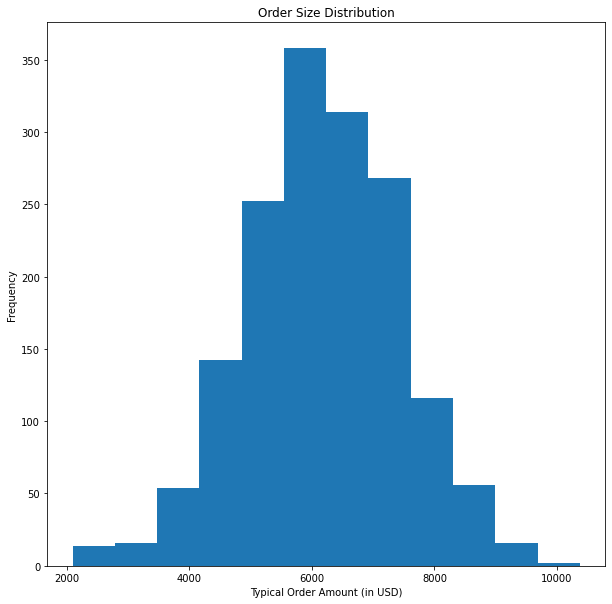

In [3]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10),)
hist=hist.set_xlabel("Typical Order Amount (in USD)")

output.trade_volume  \
                                                                     sum   
model_name            input.direction input.token_in                       
Element_Pricing_Model in              base                  1.226976e+06   
                                      fyt                   1.298294e+06   
                      out             base                  1.262946e+06   
                                      fyt                   1.187204e+06   
YieldsSpacev2         in              base                  1.226976e+06   
                                      fyt                   1.298294e+06   
                      out             base                  1.262946e+06   
                                      fyt                   1.187204e+06   

                                                     output.slippage  \
                                                                mean   
model_name            input.direction input.token_in                   
Element_Pricing_Model in              base                 -0.005648   
                                      fyt                  -0.005568   
                      out             base                  0.005673   
                                      fyt                   0.005637   
YieldsSpacev2         in              base                 -0.005003   
                                      fyt                  -0.004933   
                      out             base                  0.005025   
                                      fyt                   0.004993   

                                                                          \
                                                           std       min   
model_name            input.direction input.token_in                       
Element_Pricing_Model in              base            0.002545 -0.014753   
                                      fyt             0.002358 -0.012518   
                      out             base            0.002682  0.000581   
                                      fyt             0.002825  0.000362   
YieldsSpacev2         in              base            0.002252 -0.013055   
                                      fyt             0.002088 -0.011078   
                      out             base            0.002373  0.000516   
                                      fyt             0.002500  0.000320   

                                                                          \
                                                           max       sum   
model_name            input.direction input.token_in                       
Element_Pricing_Model in              base           -0.000959 -1.129648   
                                      fyt            -0.000688 -1.169259   
                      out             base            0.013366  1.151684   
                                      fyt             0.014670  1.076730   
YieldsSpacev2         in              base           -0.000849 -1.000664   
                                      fyt            -0.000610 -1.035871   
                      out             base            0.011824  1.020155   
                                      fyt             0.012984  0.953749   

                                                     output.fee            \
                                                           mean       std   
model_name            input.direction input.token_in                        
Element_Pricing_Model in              base             1.452660  0.434898   
                                      fyt              1.435040  0.416957   
                      out             base             1.436939  0.465022   
                                      fyt              1.428520  0.482768   
YieldsSpacev2         in              base             1.452657  0.433916   
                                      fyt              1.435067  0.416194   
                      out             base             1

,model_name,init.apy,init.percent_fee,init.days_until_maturity,init.max_order_size,init.time_stretch,init.market_price,init.target_liquidity,init.target_daily_volume,input.day,...,input.token_out,input.direction,input.pool_age,input.vault_age,input.vault_apr,input.c,input.u,output.trade_volume,output.fee,output.slippage
0,Element_Pricing_Model,10,0.2,5,5.0,11.093439,2500,10000000,5000000,1,...,fyt,in,0.00274,1.00274,1.791621,1.017916,1.017916,6172.899317,1.691787,-0.00636


,model_name,init.apy,init.percent_fee,init.days_until_maturity,init.max_order_size,init.time_stretch,init.market_price,init.target_liquidity,init.target_daily_volume,input.day,...,input.token_out,input.direction,input.pool_age,input.vault_age,input.vault_apr,input.c,input.u,output.trade_volume,output.fee,output.slippage
804,YieldsSpacev2,10,0.2,5,5.0,11.093439,2500,10000000,5000000,1,...,fyt,in,0.00274,1.00274,1.791621,1.017916,1.017916,6172.898736,1.691932,-0.005635


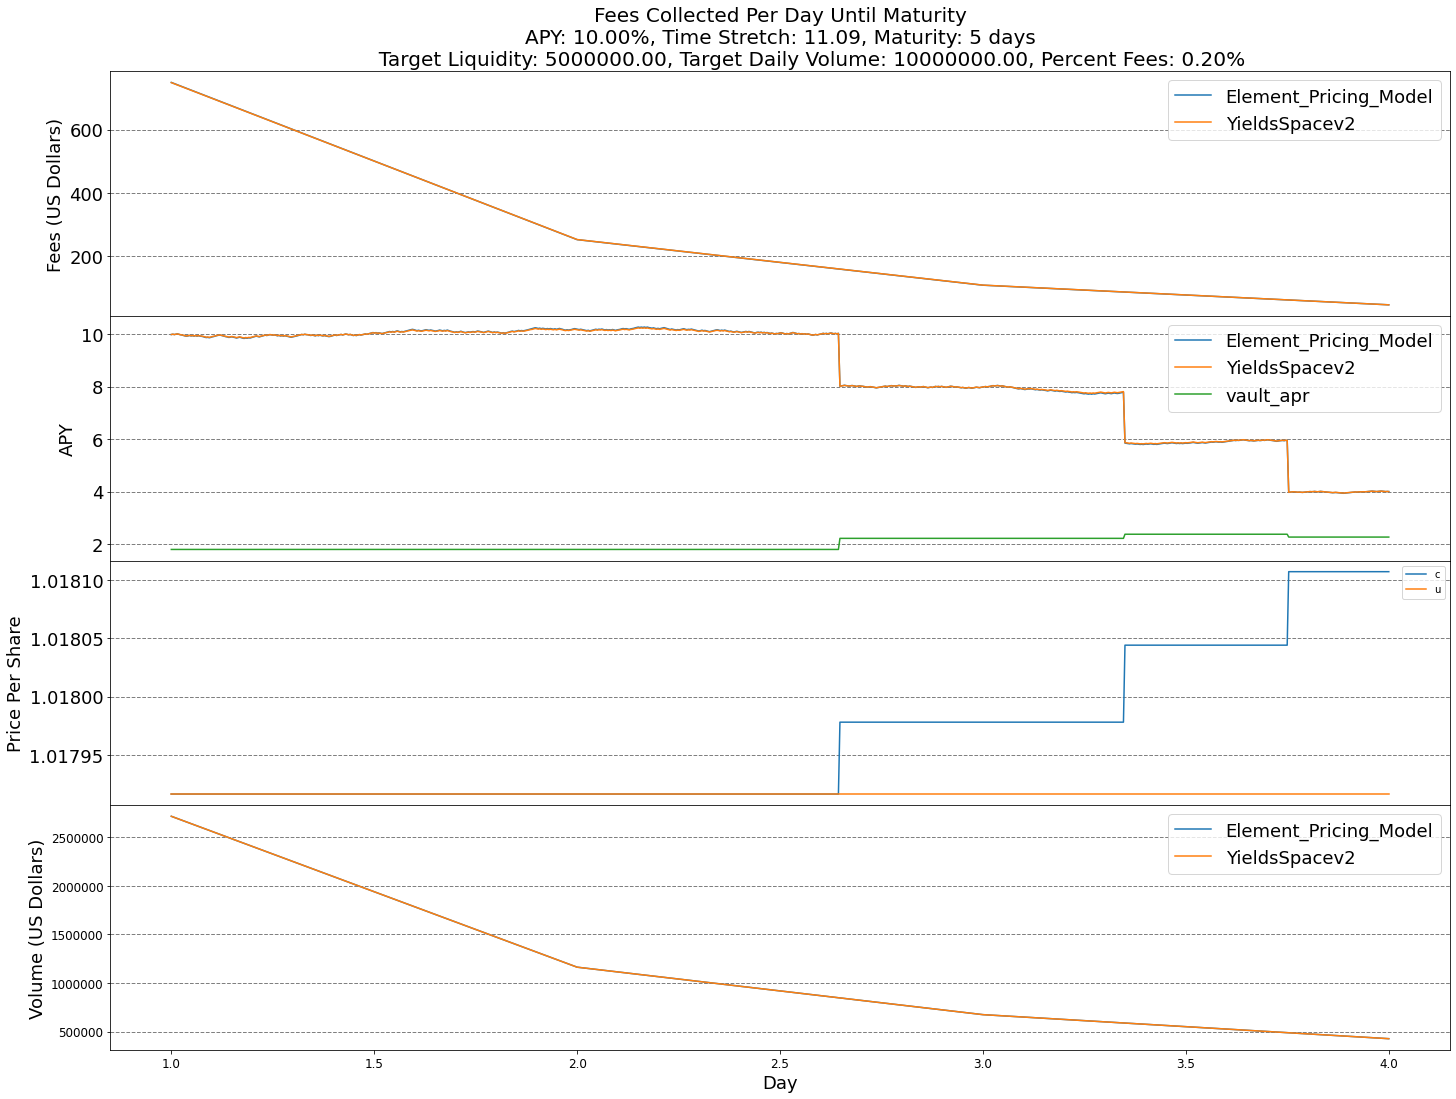

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
oldIndex = []
for (model_name,yba,g,target_liquidity,target_daily_volume) in run_matrix:
  newIndex = (df['init.market_price']==yba["market_price"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)
  if len(oldIndex)==0 or not all(newIndex==oldIndex):
    dfs.append(df[ newIndex ].reset_index(drop=True))
    oldIndex = newIndex

numPlots = 4
for idx,_df in enumerate(dfs):
  fig, ax = plt.subplots(ncols=1, nrows=numPlots,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':np.ones(numPlots)})
  # set fig background color to white
  fig.patch.set_facecolor('white')
  df_fees_volume = _df.groupby(['input.day','model_name']).agg({'output.trade_volume':['sum']\
                                  ,'output.fee':['mean','std','min','max','sum']\
                                })
  df_fees_by_trade_type = _df.groupby(['model_name','input.direction','input.token_in']).agg({'output.trade_volume':['sum']\
                                  ,'output.slippage':['mean','std','min','max','sum']\
                                  ,'output.fee':['mean','std','min','max','sum']\
                                })
  display(df_fees_by_trade_type)
                            
  df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
  df_fees_volume = df_fees_volume.reset_index()
  # display(_df)
  # display(df_fees_volume)

  for model in df_fees_volume.model_name.unique():
    ax[0] = df_fees_volume.loc[df_fees_volume.model_name==model,:].plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0],label=model)
  ax[0].set_xlabel("")
  ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
  ax[0].tick_params(axis = "both", labelsize=18)
  ax[0].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
  ax[0].xaxis.set_ticklabels([])
  title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Time Stretch: {:.2f}, Maturity: {:} days\n\
          Target Liquidity: {:.2f}, Target Daily Volume: {:.2f}, Percent Fees: {:.2f}%"\
    .format(_df['init.apy'][0],_df['init.time_stretch'][0],_df['init.days_until_maturity'][0]\
      ,_df["init.target_daily_volume"][0],_df["init.target_liquidity"][0],_df["init.percent_fee"][0])
  ax[0].set_title(title,fontsize=20)
  ax[0].legend(fontsize=18)

  currentPlot = 1
  for model in df_fees_volume.model_name.unique():
    ax[currentPlot] = _df.loc[_df.model_name==model,:].plot(x="input.trade_number",y="input.apy",figsize=(24,18),ax=ax[currentPlot],label=model)
    display(_df.loc[_df.model_name==model,:].head(1))
  ax[currentPlot] = _df.loc[_df.model_name==model,:].plot(x="input.trade_number",y="input.vault_apr",figsize=(24,18),ax=ax[currentPlot],label='vault_apr')
  ax[currentPlot].set_xlabel("")
  ax[currentPlot].set_ylabel("APY",fontsize=18)
  ax[currentPlot].tick_params(axis = "both", labelsize=18)
  ax[currentPlot].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
  ax[currentPlot].xaxis.set_ticklabels([])
  # title = "APY after each trade"
  # ax[1].set_title(title,fontsize=20)
  ax[currentPlot].legend(fontsize=18)

  currentPlot = 2
  ax[currentPlot] = _df.loc[_df.model_name==model,:].plot(x="input.trade_number",y="input.c",figsize=(24,18),ax=ax[currentPlot],label='c')
  ax[currentPlot] = _df.loc[_df.model_name==model,:].plot(x="input.trade_number",y="input.u",figsize=(24,18),ax=ax[currentPlot],label='u')
  ax[currentPlot].set_ylabel("Price Per Share",fontsize=18)
  ax[currentPlot].tick_params(axis = "both", labelsize=18)
  ax[currentPlot].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
  ax[currentPlot].xaxis.set_ticklabels([])

  currentPlot = 3
  for model in df_fees_volume.model_name.unique():
    ax[currentPlot] = df_fees_volume.loc[df_fees_volume.model_name==model,:].plot(kind='line',x="input.day", y="output.trade_volume_sum",ax=ax[currentPlot],label=model)
  ax[currentPlot].set_xlabel("Day",fontsize=18)
  ax[currentPlot].set_ylabel("Volume (US Dollars)",fontsize=18)
  ax[currentPlot].tick_params(axis = "both", labelsize=12)
  ax[currentPlot].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
  ax[currentPlot].legend(fontsize=18)
  ax[currentPlot].ticklabel_format(style='plain',axis='y')
  fig.subplots_adjust(wspace=None, hspace=None)

  import os
  os.makedirs("figures", exist_ok=True)
  fig.savefig("figures/chart{}.png".format(idx+1),bbox_inches='tight')

In [5]:
df_fees_volume

,input.day,model_name,output.trade_volume_sum,output.fee_mean,output.fee_std,output.fee_min,output.fee_max,output.fee_sum
0,1,Element_Pricing_Model,2.714003e+06,1.698523,0.351647,0.656212,2.596259,749.048587
1,1,YieldsSpacev2,2.714003e+06,1.697219,0.351307,0.656362,2.593331,748.473519
2,2,Element_Pricing_Model,1.161785e+06,1.342582,0.273497,0.453646,2.275659,252.405342
3,2,YieldsSpacev2,1.161785e+06,1.344022,0.273533,0.454249,2.275835,252.676156
4,3,Element_Pricing_Model,6.734474e+05,1.004462,0.179471,0.508811,1.436803,108.481894
5,3,YieldsSpacev2,6.734474e+05,1.006867,0.179976,0.509318,1.442044,108.741587
6,4,Element_Pricing_Model,4.261845e+05,0.694037,0.130932,0.254865,1.014134,46.500498
7,4,YieldsSpacev2,4.261845e+05,0.694438,0.130965,0.254923,1.014370,46.527353


In [6]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean']).reset_index()
df_fees_agg

,index,init.apy,init.percent_fee,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,10,0.20000000,11.09343851,2500,10000000,5,5000000,1608,"2,312.85493624","9,950,840.07488119",-0.00008279,"1,990,168.01497624",1.68838410


In [7]:
#df_fees_agg.to_csv("fees.csv")
#print(df_fees_agg[['init.target_liquidity','init.target_daily_volume','output.fee_sum','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False))

print(df_fees_agg[['init.target_liquidity','output.trade_volume_sum','output.mean_daily_volume','output.apr']].to_markdown(index=False,floatfmt=(",.0f", ",.0f",",.0f",",.2f")))

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)